In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
import xgboost as xgb

# Data

In [156]:
data = pd.read_csv('2023_DS2_HW1_data_train.csv', sep = ',', decimal = '.', index_col = 'Booking_ID')

In [157]:
data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN16851,2.0,NaN,NaN,NaN,Meal Plan 1,NaN,NaN,43.0,2017.0,12.0,26.0,Offline,NaN,0.0,0.0,NaN,2.0,0.0
INN06266,1.0,NaN,NaN,2.0,Meal Plan 2,0.0,Room_Type 1,102.0,2017.0,10.0,NaN,Online,NaN,0.0,NaN,80.0,NaN,1.0
INN11285,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2018.0,5.0,NaN,Corporate,0.0,0.0,0.0,NaN,1.0,0.0


In [158]:
Booking_ID: unique identifier of each booking
no_of_adults: Number of adults
no_of_children: Number of Children
no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
type_of_meal_plan: Type of meal plan booked by the customer:
required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
lead_time: Number of days between the date of booking and the arrival date
arrival_year: Year of arrival date
arrival_month: Month of arrival date
arrival_date: Date of the month
market_segment_type: Market segment designation.
repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
booking_status: Flag indicating if the booking was canceled or not.

SyntaxError: invalid syntax (<ipython-input-158-e2e9abcf1ad0>, line 1)

In [159]:
# define list of predictors
cols_pred = list(data.columns[0:-1])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']


In [160]:
data = data.dropna(subset=['booking_status'])
data.booking_status.value_counts(dropna=False)

0.0    21774
1.0    10521
Name: booking_status, dtype: int64

In [161]:
#Kdybychom chteli stratify taky podle no_of_special_requests, museli bychom zlikvidovat unavailable data
data_train, data_rest = train_test_split(data, test_size=0.4, random_state = 12, stratify = (data[["booking_status"]]))
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12, stratify = (data_rest[["booking_status"]]))
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

C:\Users\jakub\anaconda3\lib\site-packages\pandas\core\indexing.py:1598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\jakub\anaconda3\lib\site-packages\pandas\core\indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\jakub\anaconda3\lib\site-packages\pandas\core\indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [162]:
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid')
test_mask = (data['sample'] == 'test')

In [163]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, np.mean)
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 1])
    plt.ylabel('default rate')
    plt.xlabel('month')
    plt.show()

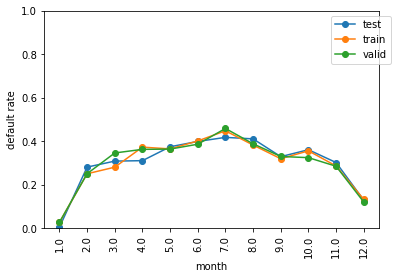

In [164]:
col_target = "booking_status"

default_rate_in_time_per_sample(data,col_target, 'arrival_month','sample')

# Data processing

In [165]:
# find columns with infinity values
cols_with_inf = []
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')
print("No other columns with infinity values")

No other columns with infinity values


# categorical variables ecoding

In [166]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, np.mean),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [167]:
total_dr = np.mean(data[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 5:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data['MTE_' + pred] = data[pred].replace(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-167-745e7e0deb1d>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MTE_' + pred] = data[pred].replace(new_vals)


# Model

In [168]:
# set best parameters to be used in XGBoost
params = {    
   # 'max_depth': 4,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)

[0]	train-auc:0.75479	test-auc:0.74260	valid-auc:0.75516
[1]	train-auc:0.77766	test-auc:0.76341	valid-auc:0.78225
[2]	train-auc:0.78554	test-auc:0.77463	valid-auc:0.78640
[3]	train-auc:0.79332	test-auc:0.78151	valid-auc:0.79053
[4]	train-auc:0.79841	test-auc:0.78475	valid-auc:0.79244
[5]	train-auc:0.80293	test-auc:0.78793	valid-auc:0.79706
[6]	train-auc:0.80753	test-auc:0.79181	valid-auc:0.80129
[7]	train-auc:0.81076	test-auc:0.79487	valid-auc:0.80431
[8]	train-auc:0.81249	test-auc:0.79567	valid-auc:0.80522
[9]	train-auc:0.81357	test-auc:0.79734	valid-auc:0.80630
[10]	train-auc:0.81649	test-auc:0.79877	valid-auc:0.80766
[11]	train-auc:0.81904	test-auc:0.79919	valid-auc:0.80879
[12]	train-auc:0.82040	test-auc:0.80004	valid-auc:0.80949
[13]	train-auc:0.82138	test-auc:0.80106	valid-auc:0.81014
[14]	train-auc:0.82522	test-auc:0.80073	valid-auc:0.81125
[15]	train-auc:0.82666	test-auc:0.80179	valid-auc:0.81189
[16]	train-auc:0.82792	test-auc:0.80238	valid-auc:0.81213
[17]	train-auc:0.82874	t

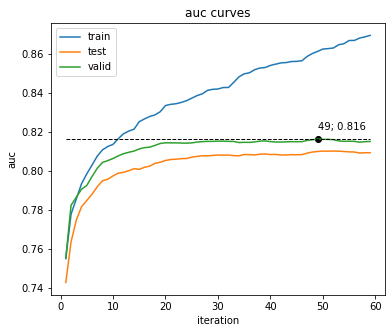

In [169]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    plt.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)
plt.xlabel('iteration')
plt.ylabel(metric)
plt.legend(loc='best')
plt.title(f'{metric} curves')
plt.show()

In [170]:
percent_nan_in_each_col = (data.isna().sum()/(len(data))*100)
print(percent_nan_in_each_col)
print(np.sort(percent_nan_in_each_col))

no_of_adults                            13.574857
no_of_children                          84.554885
no_of_weekend_nights                    76.312123
no_of_week_nights                       25.626258
type_of_meal_plan                       49.326521
required_car_parking_space              45.273262
room_type_reserved                      65.183465
lead_time                               78.783093
arrival_year                             9.180988
arrival_month                            2.774423
arrival_date                            83.303917
market_segment_type                     43.229602
repeated_guest                          76.528874
no_of_previous_cancellations             0.213655
no_of_previous_bookings_not_canceled    44.790215
avg_price_per_room                      72.237188
no_of_special_requests                  22.799195
booking_status                           0.000000
sample                                   0.000000
MTE_type_of_meal_plan                   49.326521


                               predictor   strength
0                           arrival_year  28.121881
1                 no_of_special_requests  19.803751
2                MTE_market_segment_type  11.727921
3                          arrival_month  11.489817
4                              lead_time  10.405925
5   no_of_previous_bookings_not_canceled   5.925127
6                           no_of_adults   5.918131
7                  MTE_type_of_meal_plan   5.343829
8                     avg_price_per_room   5.280331
9             required_car_parking_space   5.013137
10                     no_of_week_nights   4.749138
11                  no_of_weekend_nights   4.220304
12                          arrival_date   3.221134
13                        repeated_guest   3.157902
14                        no_of_children   3.013383
15                MTE_room_type_reserved   3.000659
16          no_of_previous_cancellations   2.485701


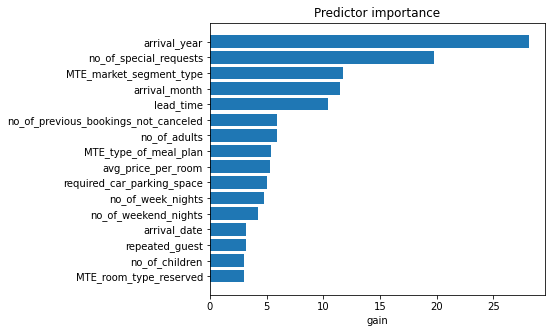

In [171]:
importance_type = 'gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])
fig = plt.figure(figsize=(6,5))
print(predictor_strength)
n_strongest = 16
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:16])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:16])
plt.xlabel(importance_type)
plt.title('Predictor importance')
plt.show()

Arrival date je blbost a ma maly vliv ,tak ho muzu vyhodt.

Number of children,repeated guest,no_of_weekend_nights, a room type reserved ma hodne unavailable a ma maly vliv, tak ho vyhodim

S otaznikem zustava
avg_price_per_room                      72.237188
MTE_type_of_meal_plan                   49.326521
required_car_parking_space              45.273262
no_of_previous_bookings_not_canceled    44.790215

nizky vliv ma take no_of_previous_cancellations   1.826715, asi proto, ze tam jsou vsechny pozorovani skoro stejny, tka to klidne muzu vyhodit, ale tim spis nechat no of previous not canceled.



no_of_previous cancelations ma fakt malo NAN a je docela uzitecne. mohlo by se pouzit pro stratifikaci. jenze ma taky skoro vzdy odpoved 0, takze zas tak zajimavy neni. Dal by se zvazit pocet mesicu.
lead_time ma hodne NaN, ale i tak je vcelku logicky uzitecny

no_of_adults: Number of adults
no_of_children: Number of Children
no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
type_of_meal_plan: Type of meal plan booked by the customer:
required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
lead_time: Number of days between the date of booking and the arrival date
arrival_year: Year of arrival date
arrival_month: Month of arrival date
arrival_date: Date of the month
market_segment_type: Market segment designation.
repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)


In [172]:
cols_pred

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

In [176]:
#cols_pred.remove(['arrival_date','no_of_children','no_of_weekend_nights','MTE_room_type_reserved','repeated_guest','no_of_previous_cancellations'])
cols_pred = [e for e in cols_pred if e not in ('arrival_date','no_of_children','no_of_weekend_nights','MTE_room_type_reserved','repeated_guest','no_of_previous_cancellations')]
cols_pred


# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']


In [177]:


# set best parameters to be used in XGBoost
params = {    
     'max_depth': 3,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)

[0]	train-auc:0.68766	test-auc:0.67843	valid-auc:0.69111
[1]	train-auc:0.71790	test-auc:0.71327	valid-auc:0.72575
[2]	train-auc:0.73349	test-auc:0.73155	valid-auc:0.74211
[3]	train-auc:0.75114	test-auc:0.74508	valid-auc:0.75411
[4]	train-auc:0.75979	test-auc:0.75433	valid-auc:0.76012
[5]	train-auc:0.76768	test-auc:0.75927	valid-auc:0.77082
[6]	train-auc:0.77015	test-auc:0.76064	valid-auc:0.77074
[7]	train-auc:0.77439	test-auc:0.76693	valid-auc:0.77798
[8]	train-auc:0.77519	test-auc:0.76896	valid-auc:0.77931
[9]	train-auc:0.77966	test-auc:0.77167	valid-auc:0.78351
[10]	train-auc:0.78253	test-auc:0.77419	valid-auc:0.78668
[11]	train-auc:0.78646	test-auc:0.77731	valid-auc:0.79080
[12]	train-auc:0.78840	test-auc:0.77839	valid-auc:0.79182
[13]	train-auc:0.79056	test-auc:0.78119	valid-auc:0.79343
[14]	train-auc:0.79216	test-auc:0.78241	valid-auc:0.79458
[15]	train-auc:0.79292	test-auc:0.78354	valid-auc:0.79539
[16]	train-auc:0.79350	test-auc:0.78497	valid-auc:0.79613
[17]	train-auc:0.79435	t

[141]	train-auc:0.83191	test-auc:0.80493	valid-auc:0.81233
[142]	train-auc:0.83223	test-auc:0.80500	valid-auc:0.81245
[143]	train-auc:0.83233	test-auc:0.80497	valid-auc:0.81239
[144]	train-auc:0.83240	test-auc:0.80502	valid-auc:0.81248
[145]	train-auc:0.83249	test-auc:0.80507	valid-auc:0.81241
[146]	train-auc:0.83276	test-auc:0.80491	valid-auc:0.81216
[147]	train-auc:0.83291	test-auc:0.80490	valid-auc:0.81215
[148]	train-auc:0.83293	test-auc:0.80494	valid-auc:0.81218
[149]	train-auc:0.83298	test-auc:0.80487	valid-auc:0.81219
[150]	train-auc:0.83311	test-auc:0.80476	valid-auc:0.81203
[151]	train-auc:0.83317	test-auc:0.80478	valid-auc:0.81204
[152]	train-auc:0.83331	test-auc:0.80478	valid-auc:0.81216
[153]	train-auc:0.83347	test-auc:0.80486	valid-auc:0.81212


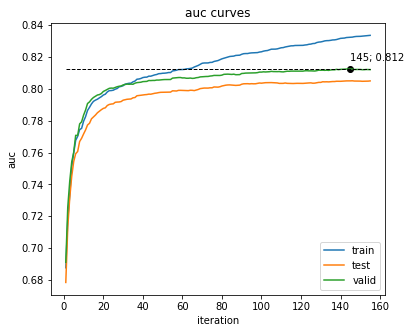

In [178]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    plt.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)
plt.xlabel('iteration')
plt.ylabel(metric)
plt.legend(loc='best')
plt.title(f'{metric} curves')
plt.show()

                               predictor   strength
0                           arrival_year  38.879046
1                 no_of_special_requests  31.019988
2                MTE_market_segment_type  17.546655
3                          arrival_month  16.346513
4                              lead_time  12.702463
5   no_of_previous_bookings_not_canceled   8.377751
6                           no_of_adults   7.913584
7             required_car_parking_space   7.818197
8                      no_of_week_nights   7.157498
9                  MTE_type_of_meal_plan   7.096951
10                    avg_price_per_room   5.505131


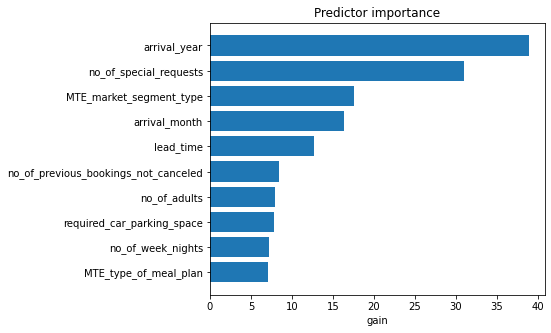

In [180]:
importance_type = 'gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])
fig = plt.figure(figsize=(6,5))
print(predictor_strength)
n_strongest = 10
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:10])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:10])
plt.xlabel(importance_type)
plt.title('Predictor importance')
plt.show()

In [63]:
booster_sklearn = xgb.XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    random_state=12,
    verbosity=1,
    eval_metric='auc',
    use_label_encoder=False,    
)

booster_sklearn.fit(
    data[train_mask][cols_pred].values, 
    data[train_mask][col_target].astype(int).values,
    eval_set=[
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values),
    ],
    verbose=True,
    early_stopping_rounds=10
)

[0]	validation_0-auc:0.75479	validation_1-auc:0.74260	validation_2-auc:0.75516
[1]	validation_0-auc:0.77766	validation_1-auc:0.76341	validation_2-auc:0.78225
[2]	validation_0-auc:0.78554	validation_1-auc:0.77463	validation_2-auc:0.78640
[3]	validation_0-auc:0.79332	validation_1-auc:0.78151	validation_2-auc:0.79053
[4]	validation_0-auc:0.79841	validation_1-auc:0.78475	validation_2-auc:0.79244
[5]	validation_0-auc:0.80293	validation_1-auc:0.78793	validation_2-auc:0.79706
[6]	validation_0-auc:0.80753	validation_1-auc:0.79181	validation_2-auc:0.80129
[7]	validation_0-auc:0.81076	validation_1-auc:0.79487	validation_2-auc:0.80431
[8]	validation_0-auc:0.81249	validation_1-auc:0.79567	validation_2-auc:0.80522
[9]	validation_0-auc:0.81357	validation_1-auc:0.79734	validation_2-auc:0.80630
[10]	validation_0-auc:0.81649	validation_1-auc:0.79877	validation_2-auc:0.80766
[11]	validation_0-auc:0.81904	validation_1-auc:0.79919	validation_2-auc:0.80879
[12]	validation_0-auc:0.82040	validation_1-auc:0.8

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=12, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [56]:
r = permutation_importance(booster_sklearn, data[test_mask][cols_pred], data[test_mask][col_target], n_repeats=6)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16'] ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'MTE_type_of_meal_plan', 'MTE_room_type_reserved', 'MTE_market_segment_type']
expected f15, f12, f13, f5, f2, f6, f0, f10, f9, f3, f1, f7, f8, f14, f11, f4, f16 in input data
training data did not have the following fields: arrival_month, no_of_previous_cancellations, no_of_adults, lead_time, no_of_previous_bookings_not_canceled, MTE_room_type_reserved, MTE_market_segment_type, arrival_year, no_of_week_nights, repeated_guest, no_of_children, required_car_parking_space, arrival_date, no_of_special_requests, no_of_weekend_nights, avg_price_per_room, MTE_type_of_meal_plan